# 3 Qubit Bit flip code

## Statevector approach


### Definitions

Throughout, we use big-endian (the first qubit is the most significant). First, we define our basis states $|0\rangle$ and $|1\rangle$, along with basic quantum gates (Pauli $X, Y, Z,$ Hadamard, and CNOT). 

In [1]:
import numpy as np
from scipy.linalg import sqrtm


# Define basis states
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0], [1]])

# Define Pauli gates
X_gate = np.array([[0, 1], [1, 0]])
Y_gate = np.array([[0,1j],[-1j,0]])
Z_gate = np.array([[1,0],[0,-1]])
Identity = np.identity(2)

#Extra gates
Hadamard = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
                               
#Define CNOT gate
cnot_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

#Print some examples
print("Pauli X gate (NOT gate): \n", X_gate) 
print("Hadamard gate: \n", Hadamard)

Pauli X gate (NOT gate): 
 [[0 1]
 [1 0]]
Hadamard gate: 
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


We now define two functions:
1. `tensor_product(*args)` instead of having to use `np.kron`.
2. `encode_logical_state(input_qubit)` to encode a single qubit state into a logical qubit using the 3-qubit bit-flip code encoding.

In [2]:
def tensor_product(*args):
    # Assume args is a list of matrices
    result = np.eye(1)
    for mat in args:
        result = np.kron(result, mat)
    return result

# Tensor product to create a 3-qubit CNOT with control on qubit 1 and target on qubit 2
# Tensor product to create a 3-qubit CNOT with control on qubit 2 and target on qubit 3
CNOT_12 = tensor_product(cnot_matrix, Identity)
CNOT_23 = tensor_product(Identity, cnot_matrix)

def encode_logical_state(input_qubit):
    initial_state = tensor_product(input_qubit, ket_0, ket_0)
    # Apply the CNOT gates
    encoded = np.dot(CNOT_23, np.dot(CNOT_12, initial_state))
    return encoded

#Example for encoding 1/sqrt2 (|0> + |1>)
print("Initial state: \n", tensor_product(np.dot(Hadamard,ket_0), ket_0, ket_0), "\n")
print("Encoded state: \n", encode_logical_state(np.dot(Hadamard,ket_0)))

Initial state: 
 [[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]] 

Encoded state: 
 [[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


Next, we implement the `error_channel` function, which introduces random bit-flip errors to a qubit based on a given error probability $p$. Qubits undergo errors independently.

In [3]:
def bit_flip_error_channel(state, p):
    # Define our error gate for the bit flip
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    
    # Potential operations for each qubit
    operations = [I, X]
    
    # Decide potential errors independently for each qubit
    error_indices = [np.random.choice([0, 1], p=[1-p, p]) for _ in range(3)]
    
    # Get the operators corresponding to the chosen errors
    error_operators = [operations[i] for i in error_indices]
    
    # Create the full error operator for the 3-qubit state
    error_to_apply = tensor_product(*error_operators)
    
    # Apply the error
    error_state = np.dot(error_to_apply, state)
    
    return error_state

Now let's append our two ancilla qubits to our (potentially) erronus state. The ancilla qubits are initialised in the $|0\rangle$ state and then entangled with the (potentailly) erronus state via CNOT gates.

In [4]:
from threequbitcode import CNOT_0_3 , CNOT_1_3, CNOT_1_4, CNOT_2_4

def add_ancilla_qubits(error_state):
    ancilla_state = tensor_product(error_state, ket_0, ket_0)
    
    ancilla_state = np.dot(CNOT_0_3, ancilla_state)
    ancilla_state = np.dot(CNOT_1_3, ancilla_state)
    ancilla_state = np.dot(CNOT_1_4, ancilla_state)
    ancilla_state = np.dot(CNOT_2_4, ancilla_state)

    return ancilla_state

Now we want to measure our ancilla qubits. We implement a function to measure the two rightmost qubits (which, in this case, is our ncilla qubits). This function calculates the probabilities of each possible outcome for the two-qubit measurement (using projectors), and then simulates a measurement result based on these probabilities using numpys `random.choice`.

In [5]:
def measure_rightmost_2_qubits(state):
    # Define projection operators for two qubits
    P_00 = tensor_product(ket_0, ket_0).dot(tensor_product(ket_0, ket_0).T)
    P_01 = tensor_product(ket_0, ket_1).dot(tensor_product(ket_0, ket_1).T)
    P_10 = tensor_product(ket_1, ket_0).dot(tensor_product(ket_1, ket_0).T)
    P_11 = tensor_product(ket_1, ket_1).dot(tensor_product(ket_1, ket_1).T)
    
    # Tensor projection operators with identity for the 3 leftmost qubits
    I_3 = np.eye(8)  # Identity for 3 qubits
    P_00_full = np.kron(I_3, P_00)
    P_01_full = np.kron(I_3, P_01)
    P_10_full = np.kron(I_3, P_10)
    P_11_full = np.kron(I_3, P_11)
    
    # Compute probabilities for each outcome
    p_00 = np.abs(state.T @ P_00_full @ state)[0, 0] #[0,0] to extract just a number
    p_01 = np.abs(state.T @ P_01_full @ state)[0, 0]
    p_10 = np.abs(state.T @ P_10_full @ state)[0, 0]
    p_11 = np.abs(state.T @ P_11_full @ state)[0, 0]

    # Ensure probabilities sum up to 1 (handling minor numerical inaccuracies)
    total_prob = p_00 + p_01 + p_10 + p_11
    p_00 /= total_prob
    p_01 /= total_prob
    p_10 /= total_prob
    p_11 /= total_prob

    # Randomly choose a measurement outcome based on the probabilities
    outcomes = ['00', '01', '10', '11']
    result = np.random.choice(outcomes, p=[p_00, p_01, p_10, p_11])

    return result



We now define a correction function that uses the measurement outcome of the ancilla qubits to apply the appropriate error correction on the physical qubits. For example, if a bit flip is detected on the first qubit, we just apply $X_0I_1I_2I_3I_4$ to our state (including ancilla qubits).

In [6]:
def correct(state, result):
    """
    Correct the state based on the measurement result of ancilla qubits.
    
    Parameters:
    - state: The 3-qubit state to be corrected. It should be a numpy array of shape (32, 1) (including ancillas).
    - result: The measurement outcome of the ancilla qubits. It should be one of ['00', '01', '10', '11'].
    
    Returns:
    - corrected_state: The corrected 3-qubit state.
    """
    # Define the correction operations
    XII = tensor_product(X_gate, Identity, Identity, Identity, Identity)
    IXI = tensor_product(Identity, X_gate, Identity, Identity, Identity)
    IIX = tensor_product(Identity, Identity, X_gate, Identity, Identity)
    
    # Apply the correct operation based on the result
    if result == '00':
        # No correction needed
        return state
    elif result == '01':
        return np.dot(IIX, state)
    elif result == '10':
        return np.dot(XII, state)
    elif result == '11':
        return np.dot(IXI, state)
    else:
        raise ValueError("Invalid measurement result. Expected one of ['00', '01', '10', '11'].")

In the `discard_ancilla_from_statevector` function, we effectively ignore the contributions from the ancilla qubits by summing over their dimensions and reshaping the result into a statevector that only represents the logical qubit. This is so that we can find the final state of the logical qubit, and check if we have corrected the error appropriately. (NOTE: This is not (?) the same as tracing out). This function is sufficent for this work, as we're only dealing with coherent errors.

In [7]:
def discard_ancilla_from_statevector(state_vector):
    """Discard the ancilla qubits from the statevector and return the state of the 3 logical qubits."""
    tensor_representation = state_vector.reshape([2]*5)  # Reshape to a 5-qubit tensor
    reduced_state = np.sum(tensor_representation, axis=(3,4))  # Sum over the ancilla qubits
    flattened_state = reduced_state.flatten().reshape((8,1))  # Flatten and reshape to column vector
    return flattened_state/np.linalg.norm(flattened_state)  # Normalize and return

Now, we combine all the previously defined components to create a simulation for the three-qubit bit-flip code. The `three_qubit_bit_code_simulation` function takes inputs of initial state and single qubit bit flip error probability and then:

1. Encodes the initial state
2. Introduce (potential) bit-flip errors on the encoded state
3. Appeneds two ancilla qubits
4. Measures the ancilla qubits to detect potential errors
5. Corrects the errors based on the measurement result of the ancilla qubits
6. Discards the ancilla qubits to obtain the final state of the 3 logical qubits
7. Compares the final state to the iniital 



In [8]:
def three_qubit_bit_code_simulation(initial_state, p, repetitions=1000):
    successes = 0
    for _ in range(repetitions):
        # The whole process: encoding, applying error, adding ancillas, measuring, correcting, discarding ancillas.
        encoded_state = encode_logical_state(initial_state)
        error_applied_state = bit_flip_error_channel(encoded_state, p)
        ancilla_added_state = add_ancilla_qubits(error_applied_state)
        result = measure_rightmost_2_qubits(ancilla_added_state)
        corrected_state = correct(ancilla_added_state, result)
        final_state = discard_ancilla_from_statevector(corrected_state)
        
        # Check if the final state matches the initial encoded state.
        if np.allclose(final_state, encoded_state):
            successes += 1

    return successes / repetitions  # Return the success rate.

Now we can analyze the effectiveness of our 3-qubit bit-flip code by simulating its success rate for varying error probabilities. We also plot the 'theoretical' success rate $1 - (3p^2 - 2p^3)$, which is the probability we stay in the correctable space (i.e. probability of only 0 or 1 bit flips occuring).

Time taken:  11.454470157623291 



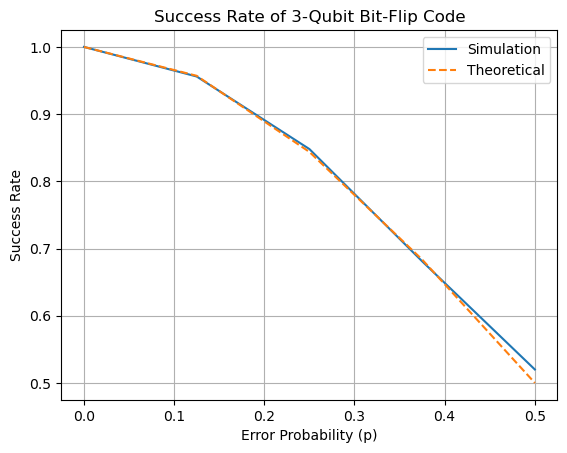

In [9]:
import matplotlib.pyplot as plt
import time

# List of error probabilities to consider.
error_probs = np.linspace(0, 0.5, 5)

start_time = time.time()
# Calculate success rates for each error probability.
success_rates = [three_qubit_bit_code_simulation(ket_0, p) for p in error_probs]
end_time = time.time()

# Theoretical success rates for the 3-qubit bit-flip code.
theoretical_success_rates = [1 - (3*p**2 - 2*p**3) for p in error_probs]
print("Time taken: ", end_time - start_time, "\n")
# Plot the results.
plt.plot(error_probs, success_rates, label='Simulation')
plt.plot(error_probs, theoretical_success_rates, label='Theoretical', linestyle='--')
plt.xlabel('Error Probability (p)')
plt.ylabel('Success Rate')
plt.title('Success Rate of 3-Qubit Bit-Flip Code')
plt.legend()
plt.grid(True)
plt.show()

### Limitations of this Simulation

1. **Bit-flip Errors Only**: Only introduces for bit-flip errors.
2. **Perfect Gates**: Gates don't introduce errors.
3. **Ideal Ancilla Qubits**: Ancilla qubits are error-free.
4. **No Measurement Errors**: Measurements are assumed to be perfect and don't themselves introduce errors.
5. **State Vector Simplification**: The method to discard ancilla qubits involves a simplification and doesn't truly represent the act of "tracing out" qubits.
6. **Connectivity**: Doesn't consider qubit connectivity.


## Density Matrix approach
Our first step is to convert our statevector $|\psi\rangle$  into a density matrix $\rho$, where $\rho = |\psi\rangle\langle\psi|$.

In [10]:
# Convert state vector to density matrix
def state_to_density_matrix(state):
    return np.outer(state, np.conj(state))

The `encode_logical_density_matrix` function encodes the logical qubit. We keep track of the density matrix by taking the tensor product of the initial state with the $|0\rangle$ states, followed by the CNOT gates. To apply a gate  $U$ to a density matrix, we use the following operation:
$$
\large \rho' = U \rho U^\dagger
$$

In [11]:
def encode_logical_density_matrix(input_density_matrix):
    # Start with the tensor product of the input density matrix and the |0><0| state for two qubits
    initial_density = tensor_product(input_density_matrix, ket_0 @ ket_0.T, ket_0 @ ket_0.T)
    
    # Apply the CNOT gates
    encoded = np.dot(CNOT_12, np.dot(initial_density, CNOT_12.T))
    encoded = np.dot(CNOT_23, np.dot(encoded, CNOT_23.T))

    return encoded

# Convert the state to a density matrix
initial_rho = state_to_density_matrix(ket_0)
encoded_rho = encode_logical_density_matrix(initial_rho)

#Example
print("Initial density matrix: \n", initial_rho, "\n") #|0><0|
print("Encoded density matrix: \n", encoded_rho) #|000><000|

Initial density matrix: 
 [[1 0]
 [0 0]] 

Encoded density matrix: 
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


As with the statevector formalism, we implement the `rho_error_channel` function, which introduces random bit-flip errors to a qubit based on a given error probability $p$. Qubits undergo errors independently.

In [12]:
def rho_error_channel(rho, p):
    # Define our error gate for the bit flip
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    
    # Potential operations for each qubit
    operations = [I, X]
    
    # Decide potential errors independently for each qubit
    error_indices = [np.random.choice([0, 1], p=[1-p, p]) for _ in range(3)]
    
    # Get the operators corresponding to the chosen errors
    error_operators = [operations[i] for i in error_indices]
    
    # Create the full error operator for the 3-qubit state
    error_to_apply = tensor_product(*error_operators)
    
    # Apply the error
    error_state = np.dot(error_to_apply, np.dot(rho, error_to_apply.T))
    
    return error_state

Now let's append our two ancilla qubits to our (potentially) erronus state. The ancilla qubits are initialised in the $|0\rangle\langle0|$ state and then entangled with the (potentailly) erronus state via CNOT gates.

In [13]:
def rho_add_ancilla_qubits(error_density_matrix):
    # Tensor product with the initialized |0><0| states for the two ancilla qubits
    ancilla_density_matrix = tensor_product(error_density_matrix, ket_0 @ ket_0.T, ket_0 @ ket_0.T)
    
    # Apply the CNOT gates on the ancilla qubits
    ancilla_density_matrix = np.dot(CNOT_0_3, np.dot(ancilla_density_matrix, CNOT_0_3.T))
    ancilla_density_matrix = np.dot(CNOT_1_3, np.dot(ancilla_density_matrix, CNOT_1_3.T))
    ancilla_density_matrix = np.dot(CNOT_1_4, np.dot(ancilla_density_matrix, CNOT_1_4.T))
    ancilla_density_matrix = np.dot(CNOT_2_4, np.dot(ancilla_density_matrix, CNOT_2_4.T))

    return ancilla_density_matrix


We implement a `rho_measure_rightmost_2_qubits` to measure the two rightmost qubits. This function calculates the probabilities of each possible outcome for the two-qubit measurement (using projectors), and then simulates a measurement result based on these probabilities using numpys `random.choice`.

For some background: to define a measurement, we need a set of projection operators $P_i$, one for each possible measurement outcome. The probability of a given density matrix $\rho$ giving outcome $i$ is
$$
p_i=\text{tr}(P_i\rho),
$$
For measurement of a single qubit, the projection operators are $P_0 = |0\rangle\langle0|$ and $P_1 = |1\rangle\langle1|$. So if we measure the the second (rightmost) qubit of the state $1/\sqrt{2}(|00\rangle +|11\rangle)$, we expect 
$$p_0 = \text{tr}\left((I \otimes |0\rangle\langle0|) \cdot \rho_{bell}\right) = 1/2$$
We then expect the post measurement (post_selected) outcome to be:

$$
\rho' =\frac{P_i\rho P_i}{p_i}.
$$

In [14]:
def rho_measure_rightmost_2_qubits(rho):
    # Define projection operators for two qubits (assuming ket_0 and ket_1 are defined)
    P_00 = np.kron(ket_0, ket_0).dot(np.kron(ket_0, ket_0).T)
    P_01 = np.kron(ket_0, ket_1).dot(np.kron(ket_0, ket_1).T)
    P_10 = np.kron(ket_1, ket_0).dot(np.kron(ket_1, ket_0).T)
    P_11 = np.kron(ket_1, ket_1).dot(np.kron(ket_1, ket_1).T)
    
    # Tensor projection operators with identity for the 3 leftmost qubits
    I_3 = np.eye(8)  # Identity for 3 qubits
    P_00_full = np.kron(I_3, P_00)
    P_01_full = np.kron(I_3, P_01)
    P_10_full = np.kron(I_3, P_10)
    P_11_full = np.kron(I_3, P_11)
    
    # Compute probabilities for each outcome
    p_00 = np.trace(P_00_full @ rho).real
    p_01 = np.trace(P_01_full @ rho).real
    p_10 = np.trace(P_10_full @ rho).real
    p_11 = np.trace(P_11_full @ rho).real

    # Randomly choose a measurement outcome based on the probabilities
    outcomes = ['00', '01', '10', '11']
    probabilities = [p_00, p_01, p_10, p_11]
    chosen_outcome = np.random.choice(outcomes, p=probabilities)

    
    # Collapse the density matrix onto the chosen outcome
    if chosen_outcome == '00':
        rho_post = (P_00_full @ rho @ P_00_full.T) / p_00
    elif chosen_outcome == '01':
        rho_post = (P_01_full @ rho @ P_01_full.T) / p_01
    elif chosen_outcome == '10':
        rho_post = (P_10_full @ rho @ P_10_full.T) / p_10
    else:  # '11'
        rho_post = (P_11_full @ rho @ P_11_full.T) / p_11
    
    
    return chosen_outcome, rho_post



We now define a correction function that uses the measurement outcome of the ancilla qubits to apply the appropriate error correction on the physical qubits. For example, if a bit flip is detected on the first qubit, we just apply $X_0I_1I_2I_3I_4$ to our state (including ancilla qubits). We do have the option of tracing out the ancilla qubits first and then correcting, but we haven't yet done this.

In [15]:
def rho_correct_density_matrix(rho, result):
    """
    Correct the density matrix based on the measurement result of ancilla qubits.
    
    Parameters:
    - rho: The density matrix to be corrected. It should be a numpy array of shape (32, 32) (including ancillas).
    - result: The measurement outcome of the ancilla qubits. It should be one of ['00', '01', '10', '11'].
    
    Returns:
    - corrected_rho: The corrected density matrix.
    """
    # Define the correction operations
    XII = tensor_product(X_gate, Identity, Identity, Identity, Identity)
    IXI = tensor_product(Identity, X_gate, Identity, Identity, Identity)
    IIX = tensor_product(Identity, Identity, X_gate, Identity, Identity)
    
    # Apply the correct operation based on the result
    if result == '00':
        # No correction needed
        return rho
    elif result == '01':
        return IIX @ rho @ IIX.T
    elif result == '10':
        return XII @ rho @ XII.T
    elif result == '11':
        return IXI @ rho @ IXI.T
    else:
        raise ValueError("Invalid measurement result. Expected one of ['00', '01', '10', '11'].")


The `rho_three_qubit_bit_code_simulation` function simulates the entire process of detecting and correcting errors via the three-qubit bit-flip code using density matrices. We calcualte the `fidelity`, which is given by
$$
\large F(\rho,\sigma) = \left(\text{tr}\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}\right)^2
$$
for two states $\rho$ and $\sigma$. In our case, as we're just working with pure states, this is $F(\rho\sigma) = |\langle \psi_\rho| \psi_\sigma\rangle|$, i.e. success rate. We also calculate the partial trace of the system, tracing out the ancilla qubits via the method described [here](https://scicomp.stackexchange.com/questions/27496/calculating-partial-trace-of-array-in-numpy).

In [16]:
def fidelity(rho, sigma):
    """
    Compute the fidelity between two density matrices, which quantifies the closeness of two quantum states.

    Parameters:
    rho (np.ndarray): The first density matrix, representing a quantum state.
    sigma (np.ndarray): The second density matrix, representing a quantum state.

    Returns:
    float: The fidelity, ranging from 0 to 1, where 1 indicates identical states.
    """
    # Compute the square root of the first density matrix
    sqrt_rho = sqrtm(rho)
    # Form the product of sqrt(rho), sigma, and sqrt(rho)
    product = np.dot(sqrt_rho, np.dot(sigma, sqrt_rho))
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)
    # The fidelity is the square of the trace of sqrt_product
    return np.real((np.trace(sqrt_product))**2) # Taking the real part to avoid any small imaginary parts due to numerical errors

def rho_three_qubit_bit_code_simulation(initial_density_matrix, p, repetitions=1000):
    fidelities = 0
    for _ in range(repetitions):
        # The whole process: encoding, applying error, adding ancillas, measuring, correcting, discarding ancillas.
        
        encoded_density = encode_logical_density_matrix(initial_density_matrix)
        
        error_applied_density = rho_error_channel(encoded_density, p)

        ancilla_added_density = rho_add_ancilla_qubits(error_applied_density)

        result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
        
        corrected_density = rho_correct_density_matrix(rho_post, result)

        #Partial trace calculation(will link to stack exchange soon...)
        reshaped_array = corrected_density.reshape([8, 4, 8, 4])
        
        final_density = np.einsum('jiki->jk', reshaped_array)
        
        # Compute the fidelity between the final and the initial encoded state.
        fidelities += fidelity(final_density, encoded_density)

    return fidelities / repetitions  # Return the average fidelity

Now we can analyze the effectiveness of our 3-qubit bit-flip code by simulating its success rate for varying error probabilities. We also plot the 'theoretical' fidelity $1 - (3p^2 - 2p^3)$, which is the probability we stay in the correctable space (i.e. probability of only 0 or 1 bit flips occuring).

Time taken:  12.524280786514282 



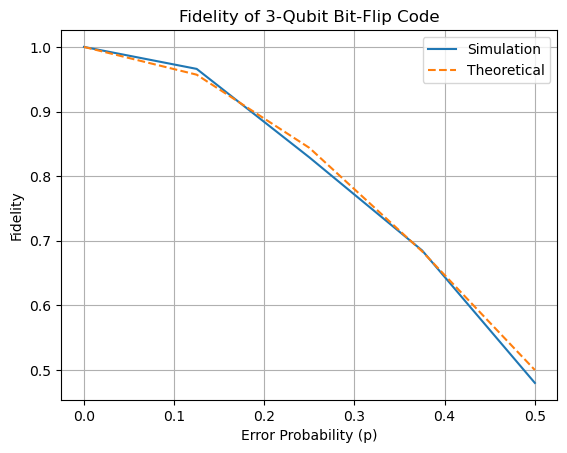

In [17]:
# List of error probabilities to consider.
error_probs = np.linspace(0, 0.5, 5)

start_time = time.time()
# Calculate average fidelities for each error probability.
fidelities = [rho_three_qubit_bit_code_simulation(state_to_density_matrix(ket_0), p) for p in error_probs]
end_time = time.time()

# Theoretical fidelities for the 3-qubit bit-flip code.
theoretical_fidelities = [1 - (3*p**2 - 2*p**3) for p in error_probs] #This is just the same as success rate for this simulation
print("Time taken: ", end_time - start_time, "\n")

# Plot the results.
plt.plot(error_probs, fidelities, label='Simulation')
plt.plot(error_probs, theoretical_fidelities, label='Theoretical', linestyle='--')
plt.xlabel('Error Probability (p)')
plt.ylabel('Fidelity')
plt.title('Fidelity of 3-Qubit Bit-Flip Code')
plt.legend()
plt.grid(True)
plt.show()